### Holiday Statistics Analysis
#### Sharan Sokhi (ss1148)

In [ ]:
# Imports (update throughout as necessary)
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt # just to format confusion matrix

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

import re
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

#### Data loading and cleaning

Notes:
* No null values found
* No duplicate values found

In [ ]:
# Data loading
data10 = pd.read_csv('./datasets/dataset-of-10s.csv')
data00 = pd.read_csv('./datasets/dataset-of-00s.csv')
data90 = pd.read_csv('./datasets/dataset-of-90s.csv')
data80 = pd.read_csv('./datasets/dataset-of-80s.csv')
data70 = pd.read_csv('./datasets/dataset-of-70s.csv')
data60 = pd.read_csv('./datasets/dataset-of-60s.csv')

# Data cleaning

# Drop all na values
data10 = data10.dropna()
data00 = data00.dropna()
data90 = data90.dropna()
data80 = data80.dropna()
data70 = data70.dropna()
data60 = data60.dropna()


# Add a decades column to each dataset (will be helpful when creating cumulative dataset)
data10['decade'] = [2010]*len(data10)
data00['decade'] = [2000]*len(data00)
data90['decade'] = [1990]*len(data90)
data80['decade'] = [1980]*len(data80)
data70['decade'] = [1970]*len(data70)
data60['decade'] = [1960]*len(data60)

# Check for duplicates in dataset
merged = data10.merge(data00,on=['track','artist'])
merged = merged.merge(data90,on=['track','artist'])
merged = merged.merge(data80,on=['track','artist'])
merged = merged.merge(data70,on=['track','artist'])
merged = merged.merge(data60,on=['track','artist'])
merged
# NOTE: No duplicates found

# Create cumulative dataset (from songs across all decades)
data = data10.append(data00,ignore_index=True).append(data90,ignore_index=True).append(data80,ignore_index=True).append(data70,ignore_index=True).append(data60,ignore_index=True)
data.head()
#data.tail()

# Add custom columns that will be useful later

# Duration of song in seconds
data["duration_sec"] = np.round(data["duration_ms"]*(1/1000))
data["duration_sec"]

# Loudness of sound (rounded)
data["loudness_rounded"] = np.round(data["loudness"])
data["loudness_rounded"]


0        -5.0
1       -15.0
2        -7.0
3        -6.0
4        -4.0
         ... 
41101   -12.0
41102    -6.0
41103   -23.0
41104    -8.0
41105    -8.0
Name: loudness_rounded, Length: 41106, dtype: float64

In [ ]:
data.to_csv("./data.csv")

#For a clean copy for genre analysis
cData = data.copy()
rData = data.copy()

# Load the Genre Songs from the csv into respective dataframes
christmas_songs = pd.read_csv('./datasets/christmas_hits.csv')
country_songs = pd.read_csv('./datasets/country_hits.csv')
rb_songs = pd.read_csv('./datasets/rb_hits.csv')
metal_songs = pd.read_csv('./datasets/metal_hits.csv')
hiphop_songs = pd.read_csv('./datasets/hiphop_hits.csv')

# Add a boolean value column indicating whether the song is in the playlist "Christmas Hits" by Spotify (https://open.spotify.com/playlist/37i9dQZF1DX0Yxoavh5qJV?si=96f9678a2982444d)
data['christmas'] = data.apply(lambda row: True if (row["track"] in christmas_songs["Track name"].tolist()) and (row["artist"] in christmas_songs[" Artist name"].tolist()) else False, axis=1)
data['country'] = data.apply(lambda row: True if (row["track"] in country_songs["Track name"].tolist()) and (row["artist"] in country_songs[" Artist name"].tolist()) else False, axis=1)
data['rb'] = data.apply(lambda row: True if (row["track"] in rb_songs["Track name"].tolist()) and (row["artist"] in rb_songs[" Artist name"].tolist()) else False, axis=1)
data['metal'] = data.apply(lambda row: True if (row["track"] in metal_songs["Track name"].tolist()) and (row["artist"] in metal_songs[" Artist name"].tolist()) else False, axis=1)
data['hiphop'] = data.apply(lambda row: True if (row["track"] in hiphop_songs["Track name"].tolist()) and (row["artist"] in hiphop_songs[" Artist name"].tolist()) else False, axis=1)

print("Christmas: ", len(data.loc[data['christmas'] == True]))
print("Country: ", len(data.loc[data['country'] == True]))
print("RB: ", len(data.loc[data['rb'] == True]))
print("Metal: ", len(data.loc[data['metal'] == True]))
print("Hip-Hop: ", len(data.loc[data['hiphop'] == True]))


Christmas:  22
Country:  27
RB:  10
Metal:  9
Hip-Hop:  8


In [ ]:
mask_christmas = data["christmas"] == True
mask_non_christmas = data["christmas"] == False

common_christmas_songs = data[mask_christmas]
common_non_christmas_songs = data[mask_non_christmas]

christmas_hits = common_christmas_songs[common_christmas_songs["target"] == 1]
non_christmas_hits =common_non_christmas_songs[common_non_christmas_songs["target"] == 1]

mask_christmas_mode = christmas_hits["mode"] == 1
mask_non_christmas_mode = non_christmas_hits["mode"] == 1
#non_christmas_sample = common_non_christmas_songs.sample(n=len(common_christmas_songs["mode"]))

proportion_happy_christmas = len(christmas_hits[mask_christmas_mode])/len(christmas_hits["mode"])
#proportion_happy_non_christmas = len(non_christmas_sample[mask_non_christmas_mode])/len(non_christmas_sample["mode"])

num_bootstrap = 10000
bootstrap_samples = np.random.choice(non_christmas_hits["mode"], size=(num_bootstrap, len(christmas_hits["mode"])), replace=True)
sampling_proportions = np.average(bootstrap_samples, axis=1)
non_christmas_proportion_avg = np.average(sampling_proportions)

# 51% percent men rank star wars

sd_christmas = np.sqrt(proportion_happy_christmas*(1-proportion_happy_christmas))
sd_non_christmas = np.sqrt(non_christmas_proportion_avg*(1-non_christmas_proportion_avg))

newpval = stats.ttest_ind_from_stats(mean1=proportion_happy_christmas, std1=sd_christmas, nobs1=len(christmas_hits["mode"]), mean2=non_christmas_proportion_avg, std2=sd_non_christmas, nobs2=len(christmas_hits["mode"]))
p_value_bootstrapping = newpval[1]/2
print(p_value_bootstrapping)

# Null hypothesis: True Proportion of happy in Christmas = True Proportion of happy in non-christmas
# P(christmas) = P(non-christmas), p = proportions
# P(christmas) - P(non-christmas) = 0
# P(non-christmas) = 0.90

# Alternative hypothesis: True Proportion of happy in Christmas > True Proportion of happy in non-christmas
# P(christmas) > P(non-christmas), p = proportion
# P(christmas) - P(non-christmas) > 0

# Find the SD using BRV = P(1-P), 
# SD - Christmas: P = #happy/total# = 20/22

#sd_christmas = np.std(common_christmas_songs[mask_christmas_mode]["mode"])
#sd_non_christmas = np.std(non_christmas_sample[mask_non_christmas_mode]["mode"])
#standard_error = np.sqrt((sd_christmas/len(common_christmas_songs["mode"]))+(sd_non_christmas/len(non_christmas_sample["mode"])))
#p_val = 1-stats.t.cdf((proportion_happy_christmas-proportion_happy_non_christmas)/standard_error, df=len(common_christmas_songs["mode"])+len(non_christmas_sample["mode"])-2)
#print(p_val)

#newpval = stats.ttest_ind_from_stats(mean1=proportion_happy_christmas, std1=sd_christmas, nobs1=len(common_christmas_songs["mode"]), mean2=proportion_happy_non_christmas, std2=sd_non_christmas, nobs2=len(non_christmas_sample["mode"]))


# 1. SDs are 0 cause it's a boolean value. is this ok?
# 2. P-value is 0? 
# 3. Could I use bootstrapping? 
# 4. what about (christmas) - P(non-christmas) > 0.4(?). Why not (christmas) - P(non-christmas) > 0

# https://stattrek.com/hypothesis-test/difference-in-proportions.aspx
#p = (proportion_happy_christmas * len(common_christmas_songs["mode"]) + proportion_happy_non_christmas * len(non_christmas_sample["mode"])) / (len(common_christmas_songs["mode"]) + len(non_christmas_sample["mode"]))
#se = np.sqrt(p*(1-p)*((1/len(common_christmas_songs["mode"]) + (1/len(non_christmas_sample["mode"])))))
#z = (proportion_happy_christmas-proportion_happy_non_christmas)/se
#pval = 0.997

#pval < 0.05 alpha level means reject null in favour of alterantive
#pval > 0.05 alpha level means fail to reject null

0.1123859767639733


In [ ]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

# Alpha Level
significance = 0.05

# c = christmas
# nc = non-christmas
sample_success_c, sample_size_c = (len(common_christmas_songs[mask_christmas_mode]), len(common_christmas_songs["mode"]))
sample_success_nc, sample_size_nc = (len(non_christmas_sample[mask_non_christmas_mode]), len(non_christmas_sample["mode"]))

# check our sample against Ho for Ha != Ho
successes = np.array([sample_success_c, sample_success_nc])
samples = np.array([sample_size_c, sample_size_nc])

# note, no need for a Ho value here - it's derived from the other parameters
stat, p_value = proportions_ztest(count=successes, nobs=samples, alternative='two-sided')

# report
print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))

if p_value > significance:
   print ("Fail to reject the null hypothesis - we have nothing else to say")
else:
   print ("Reject the null hypothesis - suggest the alternative hypothesis is true")

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:
# Country Songs Vs. Instrumentalness

# Hypothesis: 
# Null: Difference of means = 0
# Alternative: Mean instrumentalness of Country > Mean instrumentalness of non-country

mask_country = data["country"] == True
mask_non_country = data["country"] == False

common_country_songs = data[mask_country]
common_non_country_songs = data[mask_non_country]

country_hits = common_country_songs[common_country_songs["target"]==1]
non_country_hits = common_non_country_songs[common_non_country_songs["target"]==1]

mean_instrumental_country = np.average(country_hits["instrumentalness"])

num_bootstrap = 10000
bootstrap_samples_country = np.random.choice(non_country_hits["instrumentalness"], size=(num_bootstrap, len(country_hits["instrumentalness"])), replace=True)
sampling_proportions_country = np.average(bootstrap_samples_country, axis=1)
mean_instrumental_non_country = np.average(sampling_proportions_country)

country_sd = np.std(country_hits["instrumentalness"])
non_country_sd = np.std(non_country_hits["instrumentalness"])

newpval_country = stats.ttest_ind_from_stats(mean1=mean_instrumental_country, std1=country_sd, nobs1=len(country_hits["instrumentalness"]), mean2=mean_instrumental_non_country, std2=non_country_sd, nobs2=len(country_hits["instrumentalness"]))
p_value_bootstrapping_country = newpval_country[1]/2
print(p_value_bootstrapping_country)

#p-val is more than 0.05, so we fail to reject the null

0.11331717189302797


In [ ]:
# Instrumental Vs. Tempo 
data['isInstrumental'] = data.apply(lambda row: True if (row["instrumentalness"]>0.5) else False, axis=1)

# Mean tempo of instrumental songs = Mean tempo of non instrumental songs
# Mean tempo of instrumental songs not equal to mean tempo of non-instrumental songs

mask_instrumental = data["isInstrumental"] == True
mask_non_instrumental = data["isInstrumental"] == False

common_instrumental_songs = data[mask_instrumental]
common_non_instrumental_songs = data[mask_non_instrumental]

instrumental_hits = common_instrumental_songs[common_instrumental_songs["target"]==1]
non_instrumental_hits = common_non_instrumental_songs[common_non_instrumental_songs["target"]==1]

mean_tempo_instrumental = np.average(instrumental_hits["tempo"])

num_bootstrap = 10000
bootstrap_samples_instrumental = np.random.choice(non_instrumental_hits["tempo"], size=(num_bootstrap, len(instrumental_hits["tempo"])), replace=True)
sampling_proportions_instrumental = np.average(bootstrap_samples_instrumental, axis=1)
mean_tempo_non_instrumental = np.average(sampling_proportions_instrumental)

instrumental_sd = np.std(instrumental_hits["tempo"])
non_instrumental_sd = np.std(non_instrumental_hits["tempo"])

newpval_instrumental = stats.ttest_ind_from_stats(mean1=mean_tempo_instrumental, std1=instrumental_sd, nobs1=len(instrumental_hits["tempo"]), mean2=mean_tempo_non_instrumental, std2=non_instrumental_sd, nobs2=len(instrumental_hits["tempo"]))
p_value_bootstrapping_instrumental = newpval_instrumental[1] #No need to divide by 2 as it is a 2 tailed-test
print(p_value_bootstrapping_instrumental)

# BECAUSE WHEN U HAVE A SINGER (LESS INSTRU) - SINGING, CAN'T GO TO FAST CAUSE OF BREATHING 

#p-val is more than 0.05, so we fail to reject the null

0.5190127994561866


### Country Data Analysis

In [ ]:

country = country.rename(columns = {"Track name": "track"})

countryData = pd.merge(cData, country, on = "track", how = 'inner')

countryData = countryData.drop([" Artist name", " Album", " Playlist name", " Type", " ISRC"], axis = 1)
countryData['country'] = True
countryData

NameError: name 'country' is not defined

In [ ]:
np.random.seed(101)


cData['country'] = cData.apply(lambda row: True if (row["track"] in country["track"].tolist()) and (row["artist"] in country[" Artist name"].tolist()) else False, axis=1)
cData = cData.loc[cData['target'] == 1].reset_index(drop=True)
cData = cData.loc[cData['country'] == False].reset_index(drop=True)
cData
nCountryRowIndices = np.random.randint(len(cData), size= 200).tolist()

nCountry = cData.iloc[nCountryRowIndices , :].reset_index(drop = True)

sampleData = pd.concat([nCountry, countryData]).reset_index(drop = True)
sampleData


,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,duration_ms,time_signature,chorus_hit,sections,target,decade,duration_sec,loudness_rounded,christmas,country
0,Wonderland,Commodores,spotify:track:7tCim0aGAMujZuMicXAh5d,0.518,0.574,6,-8.352,1,0.0570,0.19300,...,229307,4,28.17783,11,1,1970,229.0,-8.0,False,False
1,Frankie And Johnny,Sam Cooke,spotify:track:4wJw1D8jb09iHuawQawYda,0.501,0.487,0,-9.799,1,0.1920,0.39900,...,180147,4,30.05113,8,1,1960,180.0,-10.0,False,False
2,Don't Say Nothin' Bad (About My Baby),The Cookies,spotify:track:5QV1ERhFeYKZfK1Y99gYG6,0.611,0.591,2,-7.138,1,0.0352,0.71700,...,165840,4,31.19564,9,1,1960,166.0,-7.0,False,False
3,Do You Miss Me,Jocelyn Enriquez,spotify:track:6hpkEh9z1tuhOQPlCunMaj,0.720,0.872,11,-8.705,0,0.0631,0.00265,...,218253,4,34.17159,9,1,1990,218.0,-9.0,False,False
4,Out Last Night,Kenny Chesney,spotify:track:4QoZGQ8woaho94v629kVl1,0.640,0.822,9,-4.954,1,0.0410,0.42000,...,199773,4,28.30111,10,1,2000,200.0,-5.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,All The Way,Calloway,spotify:track:2qx8wHW2Npc2wD1ONfR8Al,0.751,0.675,4,-13.077,0,0.0686,0.00230,...,409667,4,25.38221,16,1,1990,410.0,-13.0,False,True
254,Say You Will,Foreigner,spotify:track:5nW7RbN0mBLPts9CURNwdy,0.720,0.720,3,-7.383,0,0.0264,0.19500,...,255653,4,49.18574,12,1,1980,256.0,-7.0,False,True
255,Gentle On My Mind,Aretha Franklin,spotify:track:3r6EzxHkcX3JLzuV4a4waK,0.506,0.501,7,-12.986,0,0.0556,0.74100,...,148907,4,93.99515,6,1,1960,149.0,-13.0,False,True
256,Gentle On My Mind,Glen Campbell,spotify:track:0mLoTgCB8oU0sJGojRtvDu,0.597,0.415,3,-13.799,1,0.0323,0.18900,...,178627,4,21.93463,14,1,1960,179.0,-14.0,False,True


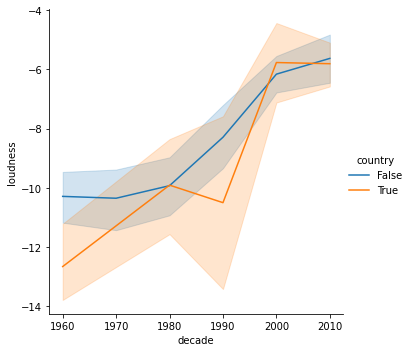

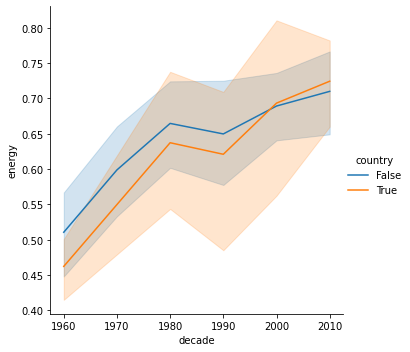

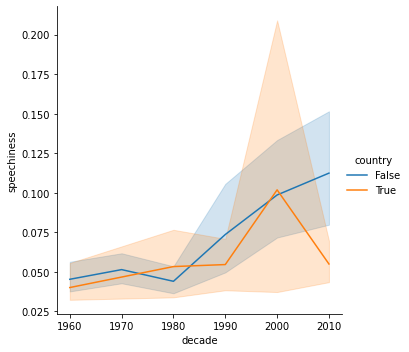

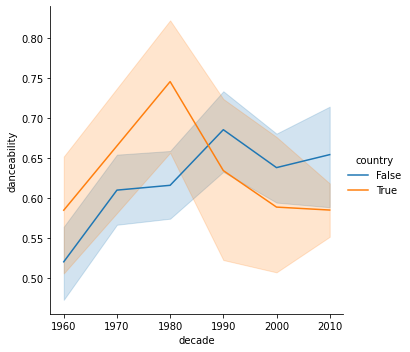

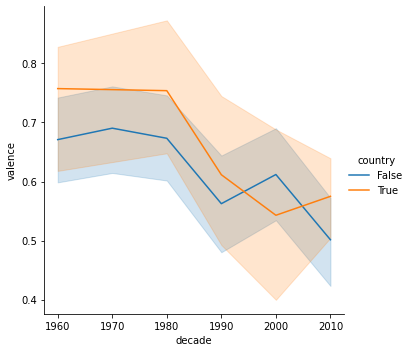

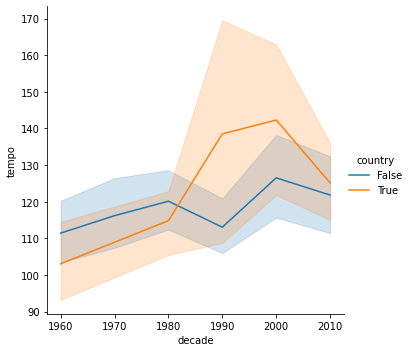

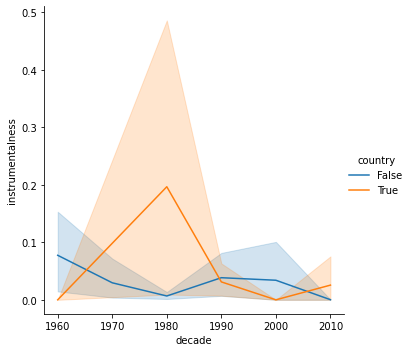

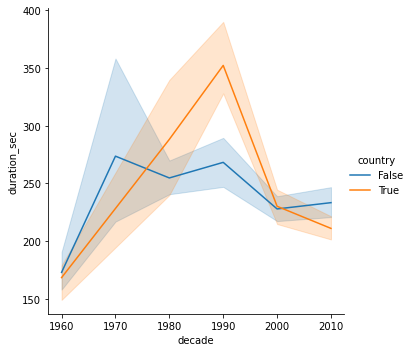

In [ ]:
# loudness vs target (Line Plot)
sns.relplot(x="decade", y="loudness", hue="country", kind="line", data = sampleData)
why are we plotting so many things lol
# energy vs target (Line Plot)
sns.relplot(x="decade", y="energy",  hue="country", kind="line", data = sampleData)

# speechiness vs target (Line Plot)
sns.relplot(x="decade", y="speechiness",  hue="country", kind="line", data = sampleData)

# speechiness vs target (Line Plot)
sns.relplot(x="decade", y="danceability", hue="country", kind="line", data = sampleData)

# valence vs target (Line Plot)
sns.relplot(x="decade", y="valence",  hue="country", kind="line", data = sampleData)

# tempo vs target (Line Plot)
sns.relplot(x="decade", y="tempo",  hue="country", kind="line", data = sampleData)

# instrumental vs target (Line Plot)
sns.relplot(x="decade", y="instrumentalness",  hue="country", kind="line", data = sampleData)

# duration over time (Line Plot)
sns.relplot(x="decade", y="duration_sec", hue="country", kind="line", data = sampleData)

### RB Data Analysis

In [ ]:
rb = pd.read_csv('./datasets/rb_hits.csv')
rb = rb.rename(columns = {"Track name": "track"})

r_bData = pd.merge(rData, rb, on = "track", how = 'inner')

r_bData = r_bData.drop([' Artist name', ' Album', ' Playlist name', ' Type', ' ISRC'], axis = 1)
r_bData['rb'] = True
r_bData


,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,duration_ms,time_signature,chorus_hit,sections,target,decade,duration_sec,loudness_rounded,christmas,rb
0,Somebody,Natalie La Rose Featuring Jeremih,spotify:track:7ioiB40H9xKs04QtIso2I3,0.830,0.5200,0,-8.714,1,0.0376,0.000792,...,189907,4,19.54918,8,1,2010,190.0,-9.0,False,True
1,Somebody,"Internet Money, Lil Tecca & A Boogie Wit da Ho...",spotify:track:735RSTb2xbtWbDtKD9XDYi,0.630,0.6710,6,-6.659,0,0.2560,0.363000,...,174333,4,49.36604,9,1,2010,174.0,-7.0,False,True
2,Somebody,Reba McEntire,spotify:track:4m3VFxVwSPk8VGoA9qcLRC,0.544,0.1690,1,-17.224,1,0.0283,0.272000,...,213560,4,42.21306,10,1,2000,214.0,-17.0,False,True
3,Somebody,Bryan Adams,spotify:track:3KTxIOIZIE7UM6vwCX4Ofv,0.545,0.7490,9,-5.485,0,0.0273,0.002450,...,283387,4,33.37022,10,1,1980,283.0,-5.0,False,True
4,The Man,Aloe Blacc,spotify:track:2stPxcgjdSImK7Gizl8ZUN,0.308,0.7690,11,-7.256,0,0.0650,0.033100,...,254880,4,29.07343,11,1,2010,255.0,-7.0,False,True
5,She Knows,J. Cole Featuring Amber Coffman & The Cults,spotify:track:282L6SR4Y8Rs0VUgtEy1Zw,0.766,0.7390,1,-10.364,1,0.0805,0.019200,...,296520,4,33.08374,10,1,2010,297.0,-10.0,False,True
6,She Knows,Ne-Yo Featuring Juicy J,spotify:track:7seTcUFOhn5caSDbiSfsp0,0.706,0.5720,8,-5.799,0,0.0326,0.026200,...,214726,4,34.82205,9,1,2010,215.0,-6.0,False,True
7,Right Now,Rihanna Featuring David Guetta,spotify:track:28OX5qT45GZBuu8CNKBOj6,0.668,0.6400,3,-5.208,0,0.0888,0.049000,...,181627,4,31.07414,9,1,2010,182.0,-5.0,False,True
8,Right Now,Van Halen,spotify:track:6N1sNzq3CArC1pMSaZTxaT,0.529,0.6620,5,-11.745,1,0.0273,0.153000,...,320867,4,37.27743,9,1,1990,321.0,-12.0,False,True
9,Right Now,Al B. Sure!,spotify:track:6oPnKLqVBDI0SoAzxoMlKN,0.635,0.5220,2,-10.498,1,0.0536,0.306000,...,354960,4,23.05400,15,1,1990,355.0,-10.0,False,True


In [ ]:
np.random.seed(101)


rData['rb'] = rData.apply(lambda row: True if (row["track"] in rb["track"].tolist()) and (row["artist"] in rb[" Artist name"].tolist()) else False, axis=1)
rData = rData.loc[rData['target'] == 1].reset_index(drop=True)
rData = cData.loc[rData['country'] == False].reset_index(drop=True)
rData
nRBRowIndices = np.random.randint(len(rData), size= 200).tolist()

nCountry = cData.iloc[nCountryRowIndices , :].reset_index(drop = True)

sampleData = pd.concat([nCountry, countryData]).reset_index(drop = True)
sampleData


In [ ]:
# loudness vs target (Line Plot)
sns.relplot(x="decade", y="loudness", hue="country", kind="line", data = sampleData)
why are we plotting so many things lol
# energy vs target (Line Plot)
sns.relplot(x="decade", y="energy",  hue="country", kind="line", data = sampleData)

# speechiness vs target (Line Plot)
sns.relplot(x="decade", y="speechiness",  hue="country", kind="line", data = sampleData)

# speechiness vs target (Line Plot)
sns.relplot(x="decade", y="danceability", hue="country", kind="line", data = sampleData)

# valence vs target (Line Plot)
sns.relplot(x="decade", y="valence",  hue="country", kind="line", data = sampleData)

# tempo vs target (Line Plot)
sns.relplot(x="decade", y="tempo",  hue="country", kind="line", data = sampleData)

# instrumental vs target (Line Plot)
sns.relplot(x="decade", y="instrumentalness",  hue="country", kind="line", data = sampleData)

# duration over time (Line Plot)
sns.relplot(x="decade", y="duration_sec", hue="country", kind="line", data = sampleData)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=162d76af-48a2-4f75-9aef-34643a48aa39' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>